<h1><center><b>Digit Recognition with CNN</b></center></h1>

<br><br>
<h2>1. Overview</h2>

<p>Kaggle has provided a dataset consisting of hand drawn numerical digits. The goal is to train a machine learning model that can accurately predict the digit that is represented in a given image. For this project, I utilized keras to build and train a convolutional neural network (CNN).</p>

In [1]:
import matplotlib.pyplot as plt
import gc, os
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import seaborn as sn
from tensorflow import keras
from torchvision import transforms
from PIL import Image
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# for markdown styling
from IPython.core.display import HTML
css = open("style/custom.css", "r").read()
HTML(css)

<br><br><br><br>
<p>After loading the data, we can see that there are <code>10</code> unique target values in our dataset. Each value corresponds with a digit that we need to classify.</p>

In [3]:
df = pd.read_csv('data/train.csv')
Y = df[['label']].copy()
X = df.drop(['label'],axis=1).copy()

In [4]:
Y['label'].unique()

array([1, 0, 4, 7, 3, 5, 8, 9, 2, 6], dtype=int64)

In [5]:
print(X.shape)
print(Y.shape)

(42000, 784)
(42000, 1)


<br><br><br><br>
<h2>2. Data Preprocessing</h2>

<p>In this section, I will be preprocessing our data prior to applying a model to it.</h4><br>

It's typically better to work with values that scale from 0 to 1, so here I normalize the values by performing element-wise division to our data with the highest possible float in an image: <code>255.0</code>.

The shape of our data is also not the format that we need. I used numpy to reshape the array from <code>(42000, 784)</code> to <code>(42000, 28, 28, 1)</code>. In order to utilize keras, we need to set our images to comply with their input shape requirement: <code>(batch size, height, width, depth)</code>.
</p>

In [6]:
# normalize X values
X = X / 255.0

# reshape array
X = X.values.reshape(-1,28,28,1)

In [7]:
print(X.shape)

(42000, 28, 28, 1)


<br><br><br><br>
<p>Now, let's take a look at a random image to see what we're working with.</p>

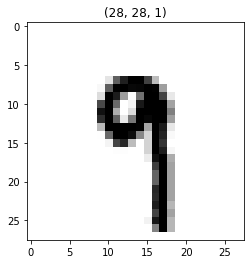

In [8]:
idx = np.random.randint(0, len(X), dtype=int)
rand_im = X[idx]
plt.title(str(rand_im.shape))
plt.imshow(rand_im, cmap='gray_r')

<br><br><br><br>

<p>The next step is to deal with our target array. Since this is a classification task, we'll need to one-hot encode our targets so it can be used in our keras model.

By <b>one-hot encoding</b> our targets, we are simply representing the classes in a binary format. There are <code>10</code> classes in our data: <code>0</code> to <code>9</code>. When we one-hot encode this data, we'll change the way it's represented by replacing each class with a vector of zeros. A <code>1</code> will be assigned to the index that represents that particular class for a given input.

<br>&emsp;&emsp;Ex:<br>
<br>&emsp;&emsp;&emsp;&emsp;If the target class of an image is <code>4</code>, it will be replaced with: <code>[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]</code>.
<br>&emsp;&emsp;&emsp;&emsp;The array has <code>10</code> values: <code>0</code> to <code>9</code>.
<br>&emsp;&emsp;&emsp;&emsp;A <code>1</code> is assigned to the index that represents the class for this particular image.
<br>&emsp;&emsp;&emsp;&emsp;Recall that array indexing begins at <code>0</code>, therefore, the <b>index</b> of the class <code>4</code> would be in the fifth entry of the vector.</p>

In [9]:
# one-hot encode the target array
T = Y.to_numpy().flatten()
T = (np.arange(T.max()+1) == T[:,None]).astype(int)

In [10]:
print('\n\nTarget Class Before and After Encoding:\n\n')

for i in range(5):
    idx = np.random.randint(0, len(T), dtype=int)
    print('\n\t', Y['label'].iloc[idx], ' --> ', T[idx])



Target Class Before and After Encoding:



	 1  -->  [0 1 0 0 0 0 0 0 0 0]

	 0  -->  [1 0 0 0 0 0 0 0 0 0]

	 9  -->  [0 0 0 0 0 0 0 0 0 1]

	 2  -->  [0 0 1 0 0 0 0 0 0 0]

	 5  -->  [0 0 0 0 0 1 0 0 0 0]


<br><br><br><br>
<p>Now that we've reformatted our data, it's time to split it into a train and test set.

Here, I shuffled the indices to randomize the assortment of the data. Then I simply created a ratio to split the data into <code>Xtrain</code>, <code>Xtest</code>, <code>Ttrain</code> and <code>Ttrain</code>. The <code>X</code> arrays are the images and <code>T</code> arrays are the target classes.
</p>

In [11]:
# shuffle indices and partition data into train and test sets
N = X.shape[0]
idxs = np.random.permutation(N)

# split dataset into a 1/5 ratio
split = 0.8
ratio = int(round(N * split))

# assign first ratio to the training sets
Xtrain = X[idxs[0:ratio], :]
Ttrain = T[idxs[0:ratio], :]

# assign remaining values to the test sets
Xtest = X[idxs[ratio:], :]
Ttest = T[idxs[ratio:], :]

In [12]:
print("Train data shape: {}".format(Xtrain.shape))
print("Train target shape: {}".format(Ttrain.shape))
print("Test data shape: {}".format(Xtest.shape))
print("Test target shape: {}".format(Ttest.shape))

Train data shape: (33600, 28, 28, 1)
Train target shape: (33600, 10)
Test data shape: (8400, 28, 28, 1)
Test target shape: (8400, 10)


<br><br><br><br>
<p>Just taking a look at a random image to see how the data held up.</p>

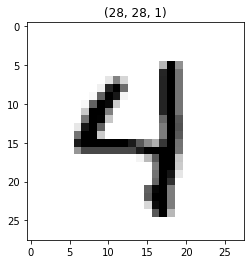

In [13]:
idx = np.random.randint(0, len(Xtrain), dtype=int)
rand_im = Xtrain[idx]
plt.title(str(rand_im.shape))
plt.imshow(rand_im, cmap='gray_r')

<br><br><br><br>
<h2>3. Setting up the Model</h2>

<p>In this section, I used the <code>keras</code> library to create and train a model using our data. The model I used is based off of the deep learning architecture, <b>LeNet-5</b>, with some minor adjustments.

<b>LeNet-5</b> was a convolutional neural network architecture proposed by the famous computer scientist, Yann LeCun. The model efficiently recognized handwritten digits that were used for postal services and banknotes.

Below is an image that details the architecture for LeNet-5.    
</p>

<figure>
    <img src="graphics/lenet-5.jpg" style="width:100%">
    <figcaption><center><a href="http://yann.lecun.com/exdb/publis/pdf/lecun-99.pdf"><i>Convolutional Neural Network</i> by Yann LeCun, 1999</a></center></figcaption>
</figure>

<br><br>

<p>As you can see, there are some notable differences in my keras implementation vs. the architecture devised by LeCun. I took the liberty of looking into <a href="https://arxiv.org/pdf/1412.6980.pdf"><i>Adam: A Method for Stochastic Optimization</i></a> to gather some insight on what kind of adjustments I should make in order to properly utilize the <b>adam</b> optimizer.
</p>

In [14]:
model = keras.Sequential([keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
                         keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
                         keras.layers.Dropout(0.25),
                         keras.layers.Conv2D(64, (3,3), activation='relu'),
                         keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
                         keras.layers.Dropout(0.25),
                         keras.layers.Flatten(),
                         keras.layers.Dense(120, activation='relu'),
                         keras.layers.Dense(84, activation='relu'),
                         keras.layers.Dense(10, activation='softmax')])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

<h3>Filters</h3><br>

```python
    keras.layers.Conv2D(32, (5,5), activation='relu', input_shape=(28,28,1)),
    keras.layers.Conv2D(64, (5,5), activation='relu'),
```

<br>

<body>
    
    <p>The first arguments for our convolution layers, <code>32</code> and <code>64</code>, correspond to the number of filters of size <code>(5,5)</code>. As far as I know, there is no explicit reasoning to why the most commonly used values are in powers of 2.
        
        <br><br>However, the reason that the number of filters are always ascending is because when an image is passed through a convolutional layer, the data that is initially extracted is typically noisy. So the first layer would extract the most general features of an image, then each subsequent layer afterwards would perform more complex abstractions on it.
        
        <br><br>An example would be how we use multiple stages for filtering water. The first stage typically involves a sediment filter that prevents small minerals from passing through, followed by a carbon filter that is used to remove contaminants. Each subsequent filter further abstracts from the original source, providing clean water by the end of the process.
    </p>
    
</body>

<br>

<h3>Max Pooling</h3><br>

```python
    keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
```

<br>

<body>
    
    <p>The adjustments I made were borrowed from the network specifications that were used during the experiments in the <i>Adam</i> paper. The subsampling layers in the LeNet-5 architecture are known today as <i>average pooling layers</i>. Rather than utilizing average pooling layers, I used <i>max pooling layers</i> with a kernel size of <code>(3,3)</code> and a stride of <code>(2,2)</code>.
    
        <br><br>These layers perform specific operations that reduce the size of the inputs as they run through the network.
    
        <br><br>The <b>max pooling</b> layer simply filters each image by returning the highest value in each kernel, whereas, the <b>average pooling</b> layer filters each image by returning the average of all values in each kernel.
    </p>
    
    <br><br>
    
    <h4><center>With a kernel of <code>(2,2)</code> and stride of <code>0</code>:<br><br>| <font style="color:blue">7 2</font> <font style="color:red">1 1</font> |<br>| <font style="color:blue">3 8</font> <font style="color:red">6 0</font> |<br>| <font style="color:fuchsia">2 5</font> 9 7 |<br>| <font style="color:fuchsia">0 1</font> 4 8 |</center>
        
        <br><br><center>Max Pooling:<br><br>| <font style="color:blue">8</font> <font style="color:red">6</font> |<br>| <font style="color:fuchsia">5</font> 9 |</center>
        
        <br><br><center>Average Pooling:<br><br>| <font style="color:blue">5</font> <font style="color:red">2</font> |<br>| <font style="color:fuchsia">2</font> 7 |</center>
    </h4>
    
    <br><br>
    
    <p>The importance of pooling is to reduce a neural networks sensitivity to translations that might occur in our data. This is especially useful in scenarios where the exact location of features are less important than their general location.
    </p>
    
</body>

<br>

<h3>Dropout</h3><br>

```python
    keras.layers.Dropout(0.25),
```

<br>

<body>
    
    <p>The <b>dropout</b> layer simply tells the network which inputs to ignore. These inputs are chosen at random and an argument is provided to determine the rate of dropout during a given training step. According to <a href="https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf"><i>Dropout: A Simple Way to Prevent Neural Networks from Overfitting</i></a>, dropout is a way to reduce overfitting by allowing each epoch to train over a differently <i>thinned</i> layer.
    </p>
    
</body>

<br>

<h3>Optimizer, Loss, and Accuracy Metric</h3><br>

```python
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
```

<br>

<body>
    
    <p>After setting up the layers, I then compiled it with the default arguments for: optimizer <code>adam</code>, loss function <code>categorical_crossentropy</code> and accuracy metric <code>categorical_accuracy</code>. This slightly differs from the LeNet-5 architecture, which utilized radial basis functions and gradient descent.
    </p>
    
</body>

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

<br><br><br><br>
<h1>3.1 Training</h1>

<p>For the training phase, I utilized an epoch size of <code>8</code> with a batch size of <code>128</code>. All of the training information will be stored in <code>history</code>.</p>

In [16]:
n_epoch = 8
n_batch = 128

history = model.fit(Xtrain, # train data
                    Ttrain, # test data (train split)
                    epochs=n_epoch, # num of iterations
                    batch_size=n_batch, # size of data per epoch
                    validation_data=(Xtest, Ttest), # validate with test split data
                    verbose=1)

Epoch 1/8
263/263 [==============================] - 1s 5ms/step - loss: 0.4416 - categorical_accuracy: 0.8601 - val_loss: 0.1189 - val_categorical_accuracy: 0.9657
Epoch 2/8
263/263 [==============================] - 1s 4ms/step - loss: 0.1175 - categorical_accuracy: 0.9640 - val_loss: 0.0833 - val_categorical_accuracy: 0.9738
Epoch 3/8
263/263 [==============================] - 1s 4ms/step - loss: 0.0873 - categorical_accuracy: 0.9730 - val_loss: 0.0588 - val_categorical_accuracy: 0.9830
Epoch 4/8
263/263 [==============================] - 1s 4ms/step - loss: 0.0707 - categorical_accuracy: 0.9777 - val_loss: 0.0491 - val_categorical_accuracy: 0.9836
Epoch 5/8
263/263 [==============================] - 1s 4ms/step - loss: 0.0591 - categorical_accuracy: 0.9816 - val_loss: 0.0455 - val_categorical_accuracy: 0.9844
Epoch 6/8
263/263 [==============================] - 1s 4ms/step - loss: 0.0533 - categorical_accuracy: 0.9834 - val_loss: 0.0432 - val_categorical_accuracy: 0.9852
Epoch 7/8


<br><br><br><br>
<p>For now, I'll store the models predictions for the test set in <code>Ybase_Xbase</code> and print the validation loss and validation accuracy score.</p>

In [17]:
Ybase_Xbase = model.predict(Xtest)
score = model.evaluate(Xtest, Ttest, verbose=0)
print(f'Validation Loss: {score[0]} \nValidation Accuracy: {score[1]}')

Validation Loss: 0.037254150956869125 
Validation Accuracy: 0.9883333444595337


<br><br><br><br>
<p>I use <code>history</code> to plot the rate of change in loss and accuracy.</p>

In [18]:
keys = list(history.history.keys())
keys

['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy']

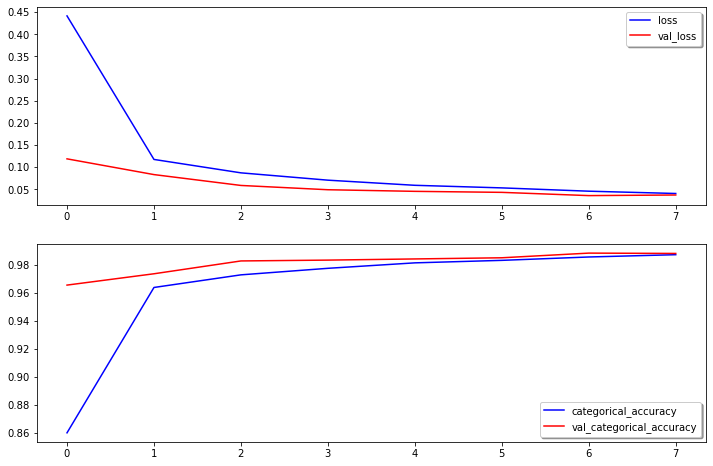

In [19]:
fig, axes = plt.subplots(2,1, figsize=(12,8))

for i, ax in enumerate(axes.flatten()):
    ax.plot(history.history[keys[i]], color='b', label=keys[i])
    ax.plot(history.history[keys[i+2]], color='r', label=keys[i+2])
    legend = ax.legend(loc='best', shadow=True)

<br><br><br><br>
<h1>4. Data Augmentation</h1>

<p>The best way to improve a models performance is to provide more data for it to train on. A simple way to do this would be to modify our current data and feed it back into the network.</p>

In [20]:
tfms = transforms.Compose([transforms.Resize(28), # resizes image: 28x28x1 -> 28x28
                               transforms.RandomAffine(degrees=(5), scale=(0.75, 1)),
                               transforms.RandomCrop((24, 24))])

<br><br><br><br>
<p>By using <code>torch.transforms</code>, I can augment our data, essentially making it so that our model never sees the exact same image more than once. Since our images our greyscaled, we can't make use of the functions that augment color. The best we can do with these simple images involves augmentations such as scaling and rotating.

Lets take a look at the random image we picked earlier and compare it to multiple augmented versions of itself.
</p>

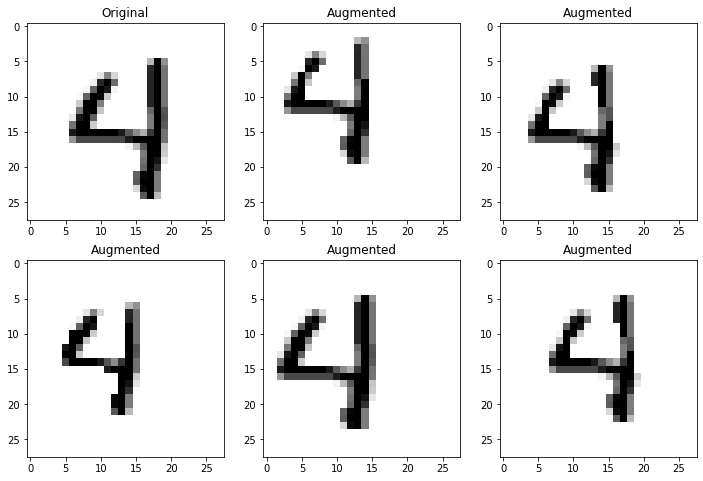

In [21]:
images = [rand_im]
im = transforms.functional.to_pil_image(np.uint8(rand_im*255)) # convert to PIL image for transformations

for i in range(5):
    tf_im = tfms(im) # output shape: 24x24
    aug_im = np.asarray(tf_im).reshape(24,24,1) # reshape to 24x24x1
    aug_im = np.append(aug_im, np.zeros((4,24,1)), axis=0) # pad zeros to get 28x24x1
    aug_im = np.append(aug_im, np.zeros((28,4,1)), axis=1) # pad zeros to get 28x28x1
    images.append(aug_im)

fig, axes = plt.subplots(2, 3, figsize=(12,8))

im_labels = ['Original', 'Augmented']

for i, ax in enumerate(axes.flatten()):
    if i > 0:
        ax.set_title('Augmented')
    else:
        ax.set_title('Original')
    
    ax.imshow(images[i], cmap='gray_r')

<br><br><br><br>
<p>Now that we know what we want to do with our images, lets make a function so we can easily call it in our train loop.</p>

In [22]:
def augment_im(im):
    ''' Transforms an input image '''
    
    # init torch transformer object
    tfms = transforms.Compose([transforms.Resize(28), # resizes image: 28x28x1 -> 28x28
                               transforms.RandomAffine(degrees=(5), scale=(0.75, 1)),
                               transforms.RandomCrop((24, 24))])
    
    # convert image to PIL image
    pilled = transforms.functional.to_pil_image(np.uint8(im*255))
    
    # pass image into transformer object, reshape, and pad zeros
    trans = tfms(pilled) # output shape: 24x24
    aug = np.asarray(trans).reshape(24,24,1) # reshape to 24x24x1
    aug = np.hstack((aug, np.zeros((24,4,1)))) # pad zeros to columns; 24x28x1
    aug = np.vstack((aug, np.zeros((4,28,1)))) # pad zeros to rows; 28x28x1
    
    return aug

<br><br><br><br>
<p>Now we can augment our test data and see how our base model performs on it.</p>

In [23]:
# augment test data and convert to numpy array
Xtest_augmented = [augment_im(image) for image in Xtest]
Xtest_augmented = np.array(Xtest_augmented)

# make predictions on base model with augmented test data
Ybase_Xaug = model.predict(Xtest_augmented)

<br><br><br><br>
<p>Since the original model never trained on augmented images, it should be a given that it would perform poorly when predicting on the new augmented test set. This, however, gives us an opportunity to retrain the model with an augmented version of our train set.
</p>

In [24]:
score = model.evaluate(Xtest_augmented, Ttest, verbose=0)
print(f'Loss Score: {score[0]} \nAccuracy: {score[1]}')

Loss Score: 716.1107177734375 
Accuracy: 0.47880953550338745


<br><br><br><br>
<h1>4.1 Retraining with Augmented Data</h1>

<p>The model used for the retraining will be the same as the base model.</p>

In [25]:
gc.collect()
keras.backend.clear_session()

In [26]:
model = keras.Sequential([keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
                         keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
                         keras.layers.Dropout(0.25),
                         keras.layers.Conv2D(64, (3,3), activation='relu'),
                         keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
                         keras.layers.Dropout(0.25),
                         keras.layers.Flatten(),
                         keras.layers.Dense(120, activation='relu'),
                         keras.layers.Dense(84, activation='relu'),
                         keras.layers.Dense(10, activation='softmax')])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

<br><br><br><br>
<p>The most notable differences between the training phase here and the original is that here, I am utilizing a for loop to iteratively augment the train set after each epoch.

<code>n_epoch</code> refers to the epoch that is passed to our keras object. However, it will only perform single epoch before a checkpoint is called. When the loop iterates, it reloads the information from the last checkpoint, augments the data, and resumes the training.

The model will most likely never see the exact same image more than once with our augmentation method.</p>

In [27]:
c_epoch = 8
n_epoch = 1
n_batch = 128
path = "tmp"

checkpoint = ModelCheckpoint(path, monitor='val_categorical_accuracy', verbose=0, mode='max') # create checkpoint object
csvlogger = CSVLogger('history.csv', separator=",", append=True) # save history to csv

if(os.path.isfile('history.csv')):
    os.remove('history.csv')

for i in range(c_epoch):
    
    # reload model
    if i > 0:
        model = load_model(path)
    
    # transform images
    Xaug = [augment_im(image) for image in Xtrain]
    
    # convert to numpy array
    Xaug = np.array(Xaug)
    
    # normalize values
    Xaug = Xaug / 255.0
    
    history_aug = model.fit(Xaug, Ttrain, # train augmented data on target set
                            epochs=n_epoch, batch_size=n_batch,
                            validation_data=(Xtest, Ttest),
                            verbose=0, # too many words
                            callbacks=[checkpoint, csvlogger]) # pass checkpoint and csvlogger args

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: tmp\assets
INFO:tensorflow:Assets written to: tmp\assets
INFO:tensorflow:Assets written to: tmp\assets
INFO:tensorflow:Assets written to: tmp\assets
INFO:tensorflow:Assets written to: tmp\assets
INFO:tensorflow:Assets written to: tmp\assets
INFO:tensorflow:Assets written to: tmp\assets
INFO:tensorflow:Assets written to: tmp\assets


<br><br><br><br>
<p>Since the information in our model is not saved after it reaches a checkpoint, I had to write the information for each epoch to a csv file. We can then pull up this csv file and use it for our historical data.</p>

In [28]:
hist_df = pd.read_csv('history.csv')

In [29]:
hist_df

,epoch,categorical_accuracy,loss,val_categorical_accuracy,val_loss
0,0,0.764256,0.707176,0.869643,0.414896
1,0,0.921101,0.247910,0.933929,0.207933
2,0,0.947679,0.167319,0.944643,0.180362
3,0,0.958423,0.131002,0.963810,0.118799
4,0,0.964286,0.110276,0.967381,0.107382
5,0,0.970030,0.098084,0.963452,0.117006
6,0,0.970357,0.095174,0.973929,0.090297
7,0,0.974434,0.082612,0.976071,0.078900


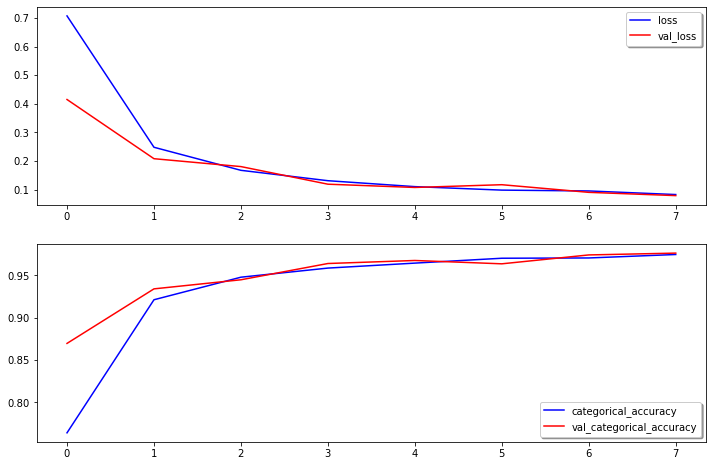

In [30]:
fig, axes = plt.subplots(2,1, figsize=(12,8))

for i, ax in enumerate(axes.flatten()):
    ax.plot(hist_df[keys[i]], color='b', label=keys[i])
    ax.plot(hist_df[keys[i+2]], color='r', label=keys[i+2])
    legend = ax.legend(loc='best', shadow=True)

<br><br><br><br>
<p>Here, we can see that the base model converged faster than the augmented model.</p>

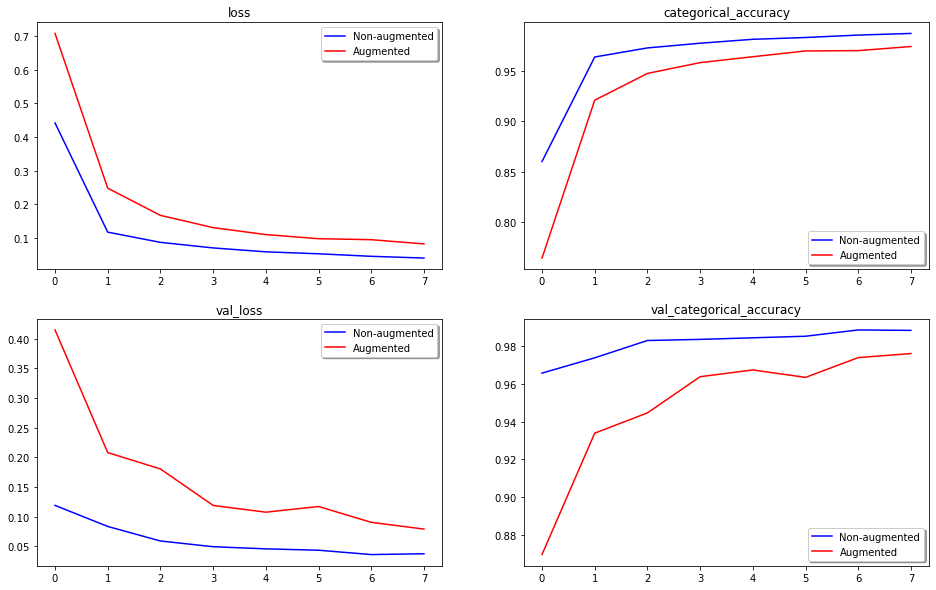

In [31]:
fig, axes = plt.subplots(2,2, figsize=(16,10))
legend = ['Non-augmented', 'Augmented']

for i, ax in enumerate(axes.flatten()):
    ax.plot(history.history[keys[i]], color='b')
    ax.plot(hist_df[keys[i]], color='r')
    ax.legend(legend, loc='best', shadow=True)
    ax.set_title(keys[i])

<br><br><br><br>
<p>Although the augmented model performed slightly worse on the base images than our initial model, it still performed pretty well.</p>

In [32]:
score_aug = model.evaluate(Xtest, Ttest, verbose=0)
print(f'Loss Score: {score_aug[0]} \nAccuracy: {score_aug[1]}')

Loss Score: 0.07890014350414276 
Accuracy: 0.9760714173316956


In [33]:
Yaug_Xbase = model.predict(Xtest) # test with base images
Yaug_Xaug = model.predict(Xtest_augmented) # test with augmented images

# free memories
Xaug = None
del Xaug
gc.collect()
keras.backend.clear_session()

<br><br><br><br>
<h1>5. Testing and Measuring Performance</h1>

<p>Before we can test the performance of our models, we will need to decode our targets.

<br>Basically, we are reversing the one-hot encoding that we performed earlier in the notebook.

</p>

In [34]:
# decode test data
Yidx, Ytrue = np.where(Ttest == 1)

# decode base predictions
Ybase_Xbase_pred = np.argmax(Ybase_Xbase, axis=1)
Ybase_Xaug_pred = np.argmax(Ybase_Xaug, axis=1)

# decode augmented predictions
Yaug_Xbase_pred = np.argmax(Yaug_Xbase, axis=1)
Yaug_Xaug_pred = np.argmax(Yaug_Xaug, axis=1)

<br><br><br><br>
<p>This is a simple function to plot the predictions along with their respective image (frame) number and target value. It can be set to only show wrong predictions.</p>

In [35]:
def plot_pred(pred, test, targets, error_only=False):
    ypred = pred # decoded predictions
    ytest = test # test set
    ytargets = targets # test classes
    
    fig, axes = plt.subplots(3,3, figsize=(16,8))
    used_idx = [] # store used images
    color = ' ' # color of title
    b = 0 # break counter
    
    for i, ax in enumerate(axes.flatten()):
        idx = np.random.randint(0, len(ytest), dtype=int)
        
        while idx in used_idx or (error_only and ypred[idx] == ytargets[idx]):
            idx = np.random.randint(0, len(ytest), dtype=int)
            b += 1
            # break condition
            if b == len(ytargets):
                b = 0
                break;
        
        used_idx.append(idx)
        
        ax.imshow(ytest[idx], cmap='gray_r')
        
        if ypred[idx] == ytargets[idx]:
            color = 'g'
        else:
            color = 'r'
        
        ax.set_title('Frame: ' + str(idx) + '\nPrediction: ' + str(ypred[idx]) + '\nTarget: ' + str(ytargets[idx]), color=color)
    
    fig.tight_layout()

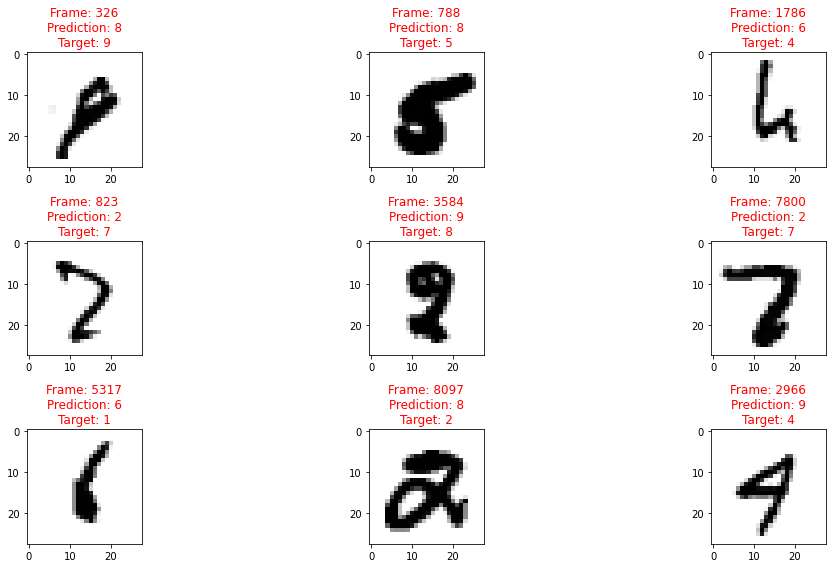

In [36]:
plot_pred(Ybase_Xbase_pred, Xtest, Ytrue, error_only=True)

<br><br><br><br>
<p>Here I created 4 confusion matrices. The first 2 will correspond with the predictions from the base model while the last 2 will correspond with the predictions from the augmented model.</p>

In [37]:
def get_df(ypred, ytest):
    cm = confusion_matrix(ypred, ytest)
    height = cm[0].size
    length = cm[1].size
    df = pd.DataFrame(cm, range(height), range(length))
    return df

In [38]:
df_Ybase_Xbase = get_df(Ybase_Xbase_pred, Ytrue)
df_Ybase_Xaug = get_df(Ybase_Xaug_pred, Ytrue)

df_Yaug_Xbase = get_df(Yaug_Xbase_pred, Ytrue)
df_Yaug_Xaug = get_df(Yaug_Xaug_pred, Ytrue)

<br><br><br><br>
<p>The array below is what the confusion matrix for the predictions on the base model look like in raw format. The rows represent true values while the columns represent the predicted values.

For every value at an index with an identical row and column, that prediction is correct.<br>

<br>&emsp;&emsp;Ex:<br>
<br>&emsp;&emsp;&emsp;&emsp;The value at index <code>(0,0)</code> corresponds to the number of <b>correct</b> predictions where <code>0</code> was the target and <code>0</code> was the prediction.
<br>&emsp;&emsp;&emsp;&emsp;The value at index <code>(0,5)</code> corresponds to the number of <b>incorrect</b> predictions where <code>0</code> was the target and <code>4</code> was the prediction.
</p>

In [39]:
print(confusion_matrix(Ybase_Xbase_pred, Ytrue))

[[829   0   2   0   0   0   5   1   1   2]
 [  0 956   0   0   2   0   0   5   0   0]
 [  0   2 844   3   0   0   0   8   1   0]
 [  0   0   0 864   0   4   0   0   0   0]
 [  0   0   0   0 763   0   1   0   1   1]
 [  0   0   0   0   0 752   0   0   0   0]
 [  1   2   0   0   1   4 805   0   0   0]
 [  0   2   2   0   0   0   0 871   0   3]
 [  1   0   3   3   1   6   0   0 816   5]
 [  0   1   1   2   6   7   0   3   5 802]]


<br><br><br><br>
<p>Here I use the <code>classification_report</code> tool to compute different rates based on a confusion matrix.

The following rates are calculated by using different values in our confusion matrix:
    
<ul>
    <li><b>Precision:</b> How often is the prediction correct overall? <br> True Positives / (True Positives + False Positives)</li><br>
    <li><b>Recall:</b> How often does it correctly predict a particular class? <br> True Positives / (True Positives + False Negatives)</li><br>
    <li><b>F1-Score:</b> The weighted average between <b>Precision</b> and <b>Recall</b>. <br> 2 x ((Precision x Recall) / (Precision + Recall))</li><br>
    <li><b>Support:</b> The total number of times the model predicted a particular class. <br> True Positives + False Positives</li>
</ul>

<br>

A macro and weighted average is also provided in the classification report.

The macro average finds the average of each label without using the values for support. The weighted average simply includes the values for support.
</p>

In [40]:
print(classification_report(Ybase_Xbase_pred, Ytrue))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       840
           1       0.99      0.99      0.99       963
           2       0.99      0.98      0.99       858
           3       0.99      1.00      0.99       868
           4       0.99      1.00      0.99       766
           5       0.97      1.00      0.99       752
           6       0.99      0.99      0.99       813
           7       0.98      0.99      0.99       878
           8       0.99      0.98      0.98       835
           9       0.99      0.97      0.98       827

    accuracy                           0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400



<br><br>
<h2>Base Model with Base Images</h2>

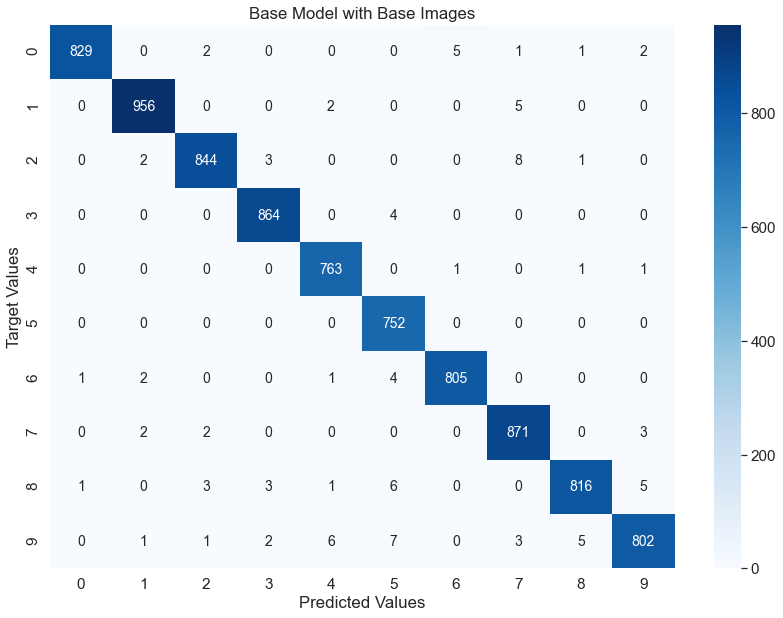

In [41]:
plt.figure(figsize=(14,10))
sn.set(font_scale=1.4) # label size
sn.heatmap(df_Ybase_Xbase, annot=True, annot_kws={"size": 14}, cmap='Blues', fmt='g') # font size
plt.title("Base Model with Base Images")
plt.xlabel("Predicted Values")
plt.ylabel("Target Values")
plt.show()

In [42]:
print(classification_report(Ybase_Xbase_pred, Ytrue))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       840
           1       0.99      0.99      0.99       963
           2       0.99      0.98      0.99       858
           3       0.99      1.00      0.99       868
           4       0.99      1.00      0.99       766
           5       0.97      1.00      0.99       752
           6       0.99      0.99      0.99       813
           7       0.98      0.99      0.99       878
           8       0.99      0.98      0.98       835
           9       0.99      0.97      0.98       827

    accuracy                           0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400



<br><br>
<h2>Base Model with Augmented Images</h2>

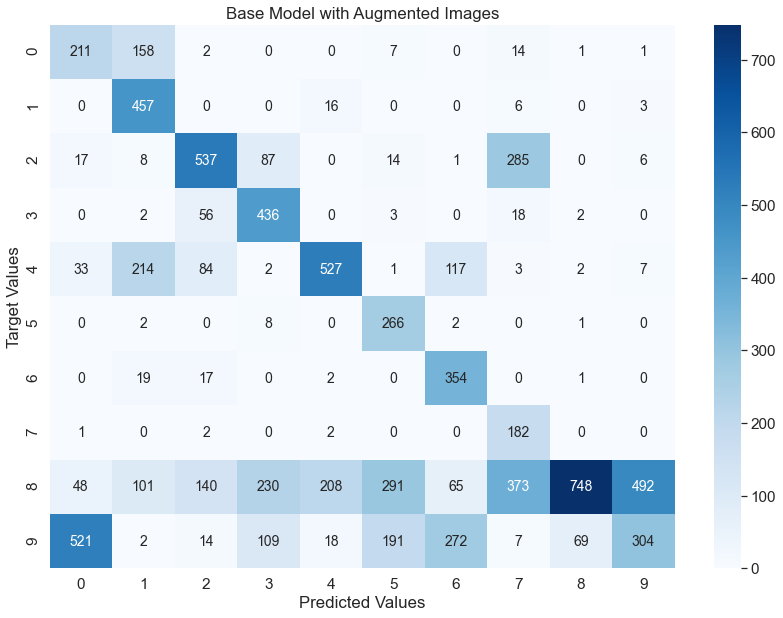

In [43]:
plt.figure(figsize=(14,10))
sn.set(font_scale=1.4) # label size
sn.heatmap(df_Ybase_Xaug, annot=True, annot_kws={"size": 14}, cmap='Blues', fmt='g') # font size
plt.title("Base Model with Augmented Images")
plt.xlabel("Predicted Values")
plt.ylabel("Target Values")
plt.show()

In [44]:
print(classification_report(Ybase_Xaug_pred, Ytrue))

              precision    recall  f1-score   support

           0       0.25      0.54      0.34       394
           1       0.47      0.95      0.63       482
           2       0.63      0.56      0.59       955
           3       0.50      0.84      0.63       517
           4       0.68      0.53      0.60       990
           5       0.34      0.95      0.51       279
           6       0.44      0.90      0.59       393
           7       0.20      0.97      0.34       187
           8       0.91      0.28      0.42      2696
           9       0.37      0.20      0.26      1507

    accuracy                           0.48      8400
   macro avg       0.48      0.67      0.49      8400
weighted avg       0.62      0.48      0.46      8400



<br><br>
<h2>Augmented Model with Base Images</h2>

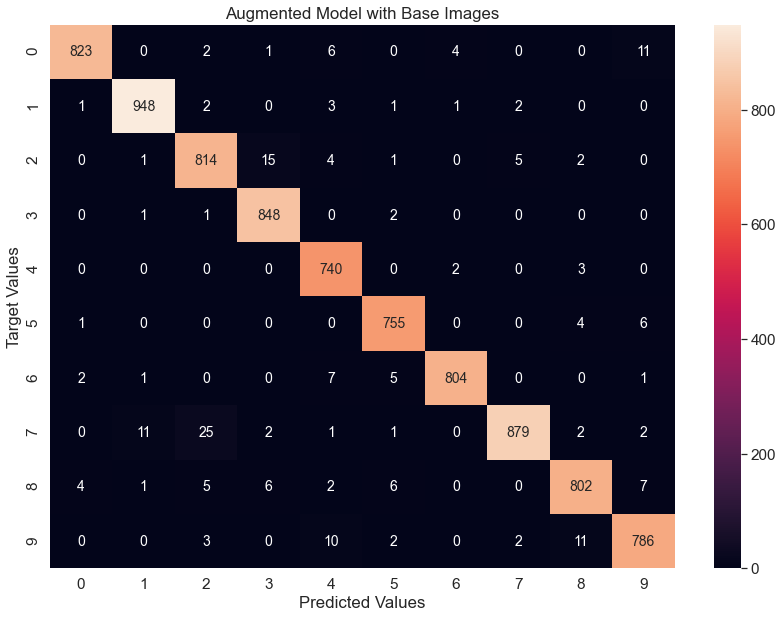

In [45]:
plt.figure(figsize=(14,10))
sn.set(font_scale=1.4) # label size
sn.heatmap(df_Yaug_Xbase, annot=True, annot_kws={"size": 14}, cmap='rocket', fmt='g') # font size
plt.title("Augmented Model with Base Images")
plt.xlabel("Predicted Values")
plt.ylabel("Target Values")
plt.show()

In [46]:
print(classification_report(Yaug_Xbase_pred, Ytrue))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       847
           1       0.98      0.99      0.99       958
           2       0.96      0.97      0.96       842
           3       0.97      1.00      0.98       852
           4       0.96      0.99      0.97       745
           5       0.98      0.99      0.98       766
           6       0.99      0.98      0.99       820
           7       0.99      0.95      0.97       923
           8       0.97      0.96      0.97       833
           9       0.97      0.97      0.97       814

    accuracy                           0.98      8400
   macro avg       0.98      0.98      0.98      8400
weighted avg       0.98      0.98      0.98      8400



<br><br>
<h2>Augmented Model with Augmented Images</h2>

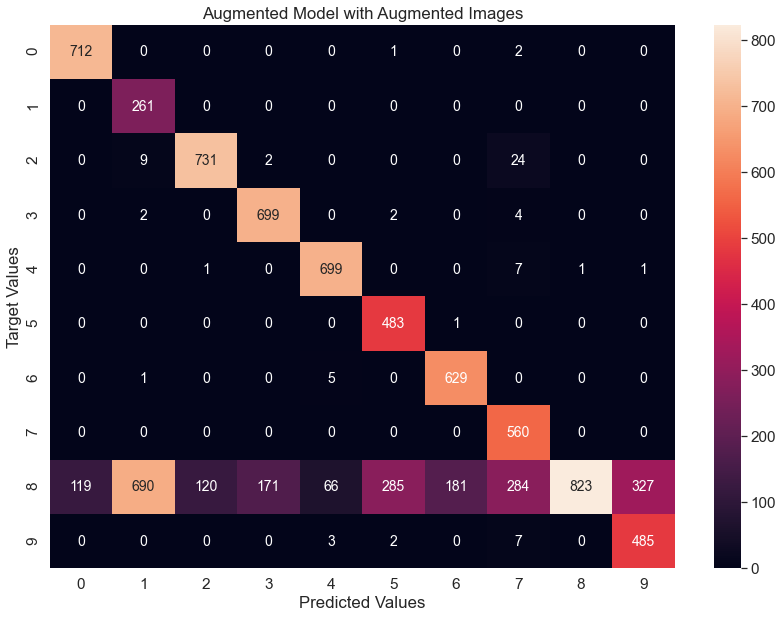

In [47]:
plt.figure(figsize=(14,10))
sn.set(font_scale=1.4) # label size
sn.heatmap(df_Yaug_Xaug, annot=True, annot_kws={"size": 14}, cmap='rocket', fmt='g') # font size
plt.title("Augmented Model with Augmented Images")
plt.xlabel("Predicted Values")
plt.ylabel("Target Values")
plt.show()

In [48]:
print(classification_report(Yaug_Xaug_pred, Ytrue))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       715
           1       0.27      1.00      0.43       261
           2       0.86      0.95      0.90       766
           3       0.80      0.99      0.89       707
           4       0.90      0.99      0.94       709
           5       0.62      1.00      0.77       484
           6       0.78      0.99      0.87       635
           7       0.63      1.00      0.77       560
           8       1.00      0.27      0.42      3066
           9       0.60      0.98      0.74       497

    accuracy                           0.72      8400
   macro avg       0.73      0.92      0.77      8400
weighted avg       0.84      0.72      0.69      8400



<br><br><br><br>
<h1>6. Conclusion</h1>

<p>We can see that our model performs exceptionally well on the original data.</p>

In [49]:
print('\n\nBase Model/Base Images\n')
print(classification_report(Ybase_Xbase_pred, Ytrue))



Base Model/Base Images

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       840
           1       0.99      0.99      0.99       963
           2       0.99      0.98      0.99       858
           3       0.99      1.00      0.99       868
           4       0.99      1.00      0.99       766
           5       0.97      1.00      0.99       752
           6       0.99      0.99      0.99       813
           7       0.98      0.99      0.99       878
           8       0.99      0.98      0.98       835
           9       0.99      0.97      0.98       827

    accuracy                           0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400



<br><br>
<p>The purpose of data augmentation in the later section was to present a way to train a model when faced with limited data.</p>

In [50]:
print('\n\nAugmented Model/Base Images\n')
print(classification_report(Yaug_Xbase_pred, Ytrue))



Augmented Model/Base Images

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       847
           1       0.98      0.99      0.99       958
           2       0.96      0.97      0.96       842
           3       0.97      1.00      0.98       852
           4       0.96      0.99      0.97       745
           5       0.98      0.99      0.98       766
           6       0.99      0.98      0.99       820
           7       0.99      0.95      0.97       923
           8       0.97      0.96      0.97       833
           9       0.97      0.97      0.97       814

    accuracy                           0.98      8400
   macro avg       0.98      0.98      0.98      8400
weighted avg       0.98      0.98      0.98      8400



<br><br>
<p>There will be times when we are looking to solve a certain issue, but do not have the appropriate size of data required to efficiently train our model. Data augmentation may not be of use in every situation, but it provides a simple solution by slightly altering the train data. This can drastically reduce overfitting if we are limited in data.</p>

In [51]:
print('\n\nBase Model/Augmented Images\n')
print(classification_report(Ybase_Xaug_pred, Ytrue))



Base Model/Augmented Images

              precision    recall  f1-score   support

           0       0.25      0.54      0.34       394
           1       0.47      0.95      0.63       482
           2       0.63      0.56      0.59       955
           3       0.50      0.84      0.63       517
           4       0.68      0.53      0.60       990
           5       0.34      0.95      0.51       279
           6       0.44      0.90      0.59       393
           7       0.20      0.97      0.34       187
           8       0.91      0.28      0.42      2696
           9       0.37      0.20      0.26      1507

    accuracy                           0.48      8400
   macro avg       0.48      0.67      0.49      8400
weighted avg       0.62      0.48      0.46      8400



In [52]:
print('\n\nAugmented Model/Augmented Images\n')
print(classification_report(Yaug_Xaug_pred, Ytrue))



Augmented Model/Augmented Images

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       715
           1       0.27      1.00      0.43       261
           2       0.86      0.95      0.90       766
           3       0.80      0.99      0.89       707
           4       0.90      0.99      0.94       709
           5       0.62      1.00      0.77       484
           6       0.78      0.99      0.87       635
           7       0.63      1.00      0.77       560
           8       1.00      0.27      0.42      3066
           9       0.60      0.98      0.74       497

    accuracy                           0.72      8400
   macro avg       0.73      0.92      0.77      8400
weighted avg       0.84      0.72      0.69      8400

